# Hyperparameter tuning with scikit-learn

## Loading the dataset

In [1]:
from braindecode.datasets.moabb import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

BNCI2014001 has been renamed to BNCI2014_001. BNCI2014001 will be removed in version 1.1.
The dataset class name 'BNCI2014001' must be an abbreviation of its code 'BNCI2014-001'. See moabb.datasets.base.is_abbrev for more information.


## Preprocessing
Signal rescaling, bandpass filtering, and standardization/

In [2]:
from braindecode.preprocessing.preprocess import (
    exponential_moving_standardize, preprocess, Preprocessor)
from numpy import multiply

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
    # Bandpass filter
    Preprocessor(exponential_moving_standardize,
                 # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Preprocess the data
preprocess(dataset, preprocessors, n_jobs=-1)

/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elaps

## Extraction of Compute Windows
One event is the demarcation of the stimulus or the beginning of the trial. In this example, we want to analyse 0.5 [s] long before the corresponding event and the duration of the event itself.

In [3]:
from braindecode.preprocessing.windowers import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


## Split Dataset into Tran and Valid

In [4]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
eval_set = splitted['1test']  # Session evaluation

## Create Model
Now we create the deep learning model! Braindecode comes with some predefined convolutional neural network architectures for raw time-domain EEG. Here, we use the ShallowFBCSPNet model from Deep learning with convolutional neural networks for EEG decoding and visualization [4]. These models are pure PyTorch deep learning models, therefore to use your own model, it just has to be a normal PyTorch nn.Module.

In [5]:
from functools import partial
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

# check if GPU is available, if True chooses to use it
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220  # random seed to make results reproducible
# Set random seed to be able to reproduce results
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

# To analyze the impact of the different parameters inside the torch model, we
# need to create partial initialisations. This is because the
# GridSearchCV of scikit-learn will try to initialize the model with the
# parameters we want to tune. If we do not do this, the GridSearchCV will
# try to initialize the model with the parameters we want to tune but
# without the parameters we do not want to tune. This will result in an
# error.
model = partial(ShallowFBCSPNet, n_chans, n_classes,
                input_window_samples=input_window_samples,
                final_conv_length='auto', )

# Send model to GPU
if cuda:
    model.cuda()

## Training
EEGClassifier is the Braindeconde object responsible for managing the training of neural networks.

In [6]:
from skorch.callbacks import LRScheduler
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier

batch_size = 16
n_epochs = 2

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    optimizer__lr=[],  # This will be handled by GridSearchCV
    batch_size=batch_size,
    train_split=ValidSplit(0.2, random_state=seed),
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)

We use scikit-learn GridSearchCV to tune hyperparameters. To be able to do this, we slice the braindecode datasets that by default return a 3-tuple to return X and y, respectively.

In [7]:
from sklearn.model_selection import GridSearchCV, KFold
from skorch.helper import SliceDataset
from numpy import array
import pandas as pd

train_X = SliceDataset(train_set, idx=0)
train_y = array([y for y in SliceDataset(train_set, idx=1)])
cv = KFold(n_splits=2, shuffle=True, random_state=42)

learning_rates = [0.00625, 0.0000625]
drop_probs = [0.2, 0.5, 0.8]

fit_params = {'epochs': n_epochs}
param_grid = {
    'optimizer__lr': learning_rates,
    'module__drop_prob': drop_probs
}

# By setting n_jobs=-1, grid search is performed
# with all the processors, in this case the output of the training
# process is not printed sequentially
search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=cv,
    return_train_score=True,
    scoring='accuracy',
    refit=True,
    verbose=1,
    error_score='raise',
    n_jobs=1,
)

search.fit(train_X, train_y, **fit_params)

# Extract the results into a DataFrame
search_results = pd.DataFrame(search.cv_results_)

Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.


Fitting 2 folds for each of 6 candidates, totalling 12 fits


/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3217        1.8104       0.3793            0.3793        4.4598  0.0063  0.1744
      2            0.4957        0.8677       0.5862            0.5862        1.7202  0.0000  0.1610


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.5217        2.0880       0.5517            0.5517        2.0244  0.0063  0.1582
      2            0.6087        1.0315       0.4828            0.4828        2.0122  0.0000  0.1612


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2783        1.4649       0.0690            0.0690        6.8549  0.0001  0.1611
      2            0.2783        1.4538       0.0690            0.0690        5.1283  0.0000  0.1592


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2000        1.5902       0.3103            0.3103        3.0387  0.0001  0.1592
      2            0.2000        1.4941       0.3103            0.3103        2.4941  0.0000  0.1589


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.4087        1.5979       0.3448            0.3448        3.7385  0.0063  0.1600
      2            0.5391        1.0078       0.4138            0.4138        2.0362  0.0000  0.1698


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3043        1.9618       0.3793            0.3793        4.7152  0.0063  0.1611
      2            0.5130        1.6277       0.4138            0.4138        3.1999  0.0000  0.1603


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2783        1.5895       0.0690            0.0690        5.1441  0.0001  0.1608
      2            0.2783        1.6594       0.0690            0.0690        3.9612  0.0000  0.1612


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2783        1.4882       0.2069            0.2069        5.0953  0.0001  0.1612
      2            0.2783        1.4685       0.2069            0.2069        4.0790  0.0000  0.1611


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3217        2.4903       0.4138            0.4138        3.1839  0.0063  0.1598
      2            0.4261        1.7236       0.4138            0.4138        1.5793  0.0000  0.1598


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2435        2.2631       0.3448            0.3448        6.4981  0.0063  0.1598
      2            0.3565        1.4870       0.4483            0.4483        2.6276  0.0000  0.1589


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2609        1.8435       0.0690            0.0690        3.5460  0.0001  0.1795
      2            0.2261        1.7590       0.2069            0.2069        3.0454  0.0000  0.1640


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2609        1.7889       0.2414            0.2414        4.0269  0.0001  0.1599
      2            0.2609        2.0504       0.2414            0.2414        3.2738  0.0000  0.1591


Can only infer signal shape of numpy arrays or and Datasets, got <class 'skorch.helper.SliceDataset'>.
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/rocioperez/Documents/Projects/AFG/Brainy/.venv/lib/python3.9/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3261        2.2354       0.2759            0.2759        4.5540  0.0063  0.3184
      2            0.5391        1.2844       0.4138            0.4138        2.1983  0.0000  0.3238


### Results Plot

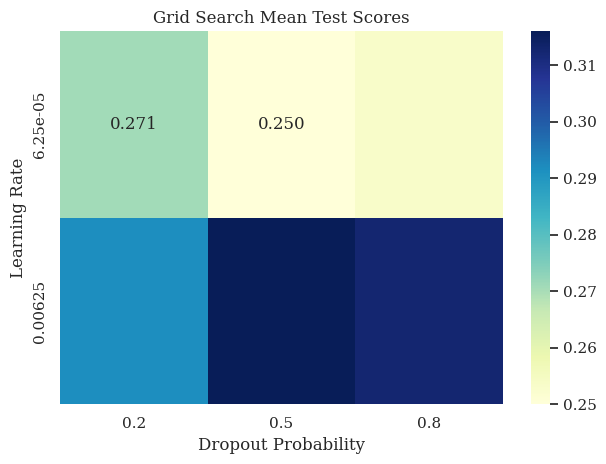

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a pivot table for the heatmap
pivot_table = search_results.pivot(index='param_optimizer__lr',
                                   columns='param_module__drop_prob',
                                   values='mean_test_score')
# Create the heatmap
fig, ax = plt.subplots()
sns.heatmap(pivot_table, annot=True, fmt=".3f",
            cmap="YlGnBu", cbar=True)
plt.title('Grid Search Mean Test Scores')
plt.ylabel('Learning Rate')
plt.xlabel('Dropout Probability')
plt.tight_layout()
plt.show()

## Get the best hyperparameters

In [9]:
best_run = search_results[search_results['rank_test_score'] == 1].squeeze()
print(
    f"Best hyperparameters were {best_run['params']} which gave a validation "
    f"accuracy of {best_run['mean_test_score'] * 100:.2f}% (training "
    f"accuracy of {best_run['mean_train_score'] * 100:.2f}%).")

eval_X = SliceDataset(eval_set, idx=0)
eval_y = SliceDataset(eval_set, idx=1)
score = search.score(eval_X, eval_y)
print(f"Eval accuracy is {score * 100:.2f}%.")

Best hyperparameters were {'module__drop_prob': 0.5, 'optimizer__lr': 0.00625} which gave a validation accuracy of 31.60% (training accuracy of 50.35%).
Eval accuracy is 37.15%.
